<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ, 2024</b></h3>

# Постановка задачи

Дан датасет с персонажами из вселенной Игры Престолов [A Wiki of Ice and Fire](http://awoiaf.westeros.org/). Необхоимо предсказать, кто из персонажей умрет, а кто останется вживых.



## Описание данных:

* **name**: Имя персонажа

* **Title**: Социальный статус или знатность

* **House**: Дом, к которому принадлежит персонаж

* **Culture**: Социальная группа, к которой принадлежит персонаж

* **book1/2/3/4/5**: Появление персонажа в книге

* **Is noble**: Знатность персонажа, основанное на титуле

* **Age**: Отсчет времени: 305 AC

* **male**: Мужчина или женщина

* **dateOfBirth**: дата рождения

* **Spouse**: Имя супруги\а персонажа

* **Father**: Имя отца персонажа

* **Mother**: Имя матери персонажа

* **Heir**: Имя наследника персонажа

* **Is married**: Represents whether the character is married

* **Is spouse alive**: Represents whether character's spouse is alive

* **Is mother alive:** Жива ли мать персонажа

* **Is heir alive:** Жив ли наследник персонажа

* **Is father alive:** Указывает, жив ли отец персонажа

* **Number dead relations:** Количество умерших персонажей, с которыми персонаж связан

* **Popularity score:** Количество внутренних входящих и исходящих ссылок на страницу персонажей в вики http://awoiaf.westeros.org

## Целевая переменная:
* **isAlive**: жив ли персонаж в книге

# Анализ и предобработка данных

## Загрузка библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Загрузка датасета

In [ ]:
!gdown 1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3 # test dataset
!gdown 1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v # train dataset

Downloading...
From: https://drive.google.com/uc?id=1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3
To: /content/game_of_thrones_test.csv
100% 37.3k/37.3k [00:00<00:00, 68.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v
To: /content/game_of_thrones_train.csv
100% 138k/138k [00:00<00:00, 74.4MB/s]


In [ ]:
data = pd.read_csv('/content/game_of_thrones_train.csv', index_col='S.No')

## Предобработка данных

### Анализ NaN

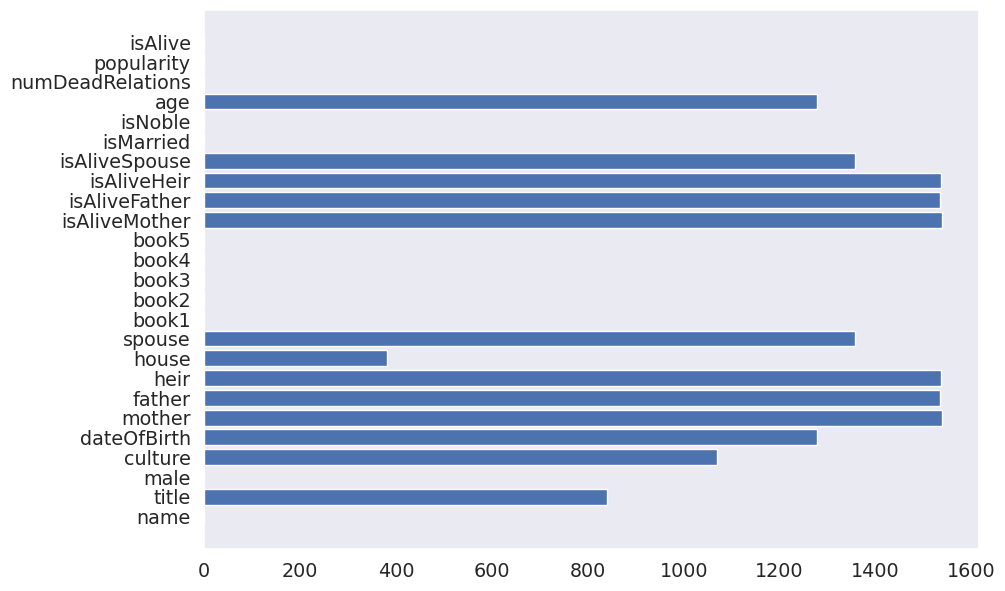

In [ ]:
nan_analyze = data.isna().sum()

plt.figure(figsize=(10,7))
plt.grid()
plt.barh(nan_analyze.index, nan_analyze.values)
plt.show()

Проанализировав гистограмму, можно заметить, что многие колонки имеют значения NaN. Удалим признаки, имеющие слишком много значений NaN (установим порог 75% значений NaN). Кроме того, так как значений NaN слишком много (примерно от 400 в каждом столбце, имеющем значения NaN), я не буду удалять объекты.

In [ ]:
threshold_NaN = (3 * len(data)) // 4  # Порог количества NaN

In [ ]:
# Заменим NaN: для категориальных признаков - модой, для числовых - медианой
for column in nan_analyze[nan_analyze != 0].index:

  if nan_analyze[column] <= threshold_NaN:  # Оставляем признак, прошедший порог
    if data[column].dtype == 'O':  # категориальный признак
      fill_var = data[column].dropna().mode()[0]
    else:  # числовой признак
      fill_var = np.quantile(data[column].dropna().values, q=0.5)
    data.fillna({column: fill_var}, inplace=True)

  else:  # Удаляем признак, не прошедший порог
    data.drop(column, axis=1, inplace=True)

In [ ]:
# Проверка, что не осталось NaN значений
data.isna().sum().sum()

0

### Создание новых признаков


* Создание признака isPopular: бинаризация по порогу
* Создание признака boolDeadRelations: бинаризация по порогу
* Упрощение признака culture: объединение схожих названий в одно

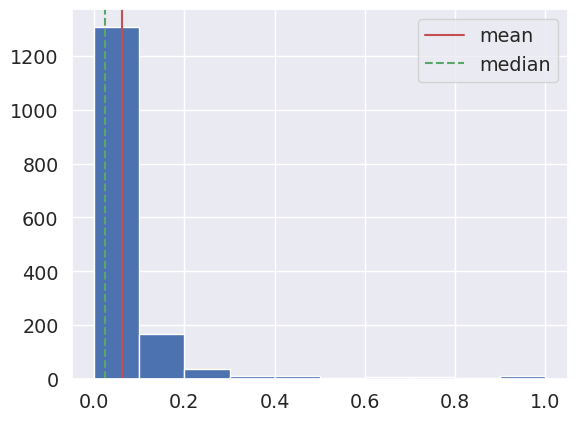

In [ ]:
plt.hist(data['popularity'])

plt.axvline(x=np.mean(data['popularity'].values), color='r', linestyle = '-', label='mean')
plt.axvline(x=np.quantile(data['popularity'].values, q=0.5), color='g', linestyle = '--', label='median')

plt.legend()
plt.show()

In [ ]:
# Изменение признака по порогу
def threshold_change(threshold, old_title, new_title):
  data[old_title] = (data[old_title] > threshold_popularity).astype(int)
  data.rename(columns={old_title: new_title}, inplace=True)


In [ ]:
# Изменение признака popularity
threshold_popularity = np.quantile(data['popularity'].values, q=0.5)  # Порог популярности
threshold_change(threshold_popularity, 'popularity', 'isPopular')

In [ ]:
# Изменение признака numDeadRelations
threshold_change(0, 'numDeadRelations', 'boolDeadRelations')

In [ ]:
# Подсказка
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

In [ ]:
cult_change = {}
for key in cult:
  for val in cult[key]:
    cult_change[val] = key

In [ ]:
data['culture'] = data['culture'].apply(lambda x: cult_change[x.lower()] if x.lower() in cult_change else 'Rare')  # Изменение признака culture

In [ ]:
# Проверка, что все значения заменены
def check():
  for key in cult:
    for value in data['culture'].value_counts().index:
      if value.lower() in cult[key] and value != key:
        return False
  return True

check()

True

### Удаление несущественных признаков

In [ ]:
data.drop(columns=['name'], inplace = True)  # Я считаю, признак name несущественнен

In [ ]:
data['title'].value_counts()

,count
title,
Ser,1146
Maester,29
Archmaester,21
Lord,19
Septon,16
...,...
Lord of Greyshield,1
Lord of the Crossing,1
Felwood,1


In [ ]:
# Так как в основном титул Ser сделаем значение 1, если титул Ser и 0 иначе
data['title'] = data['title'].apply(lambda x: 1 if x == 'Ser' else 0)

In [ ]:
data['house'].value_counts()

,count
house,
House Frey,470
Night's Watch,88
House Stark,56
House Targaryen,40
House Lannister,36
...,...
House Celtigar,1
House of Ghazeen,1
House Byrch,1


In [ ]:
# Так как очень много редких домов, сделаем им статус Rare
threshold_rare = len(data) // 30
data['house'] = data['house'].apply(lambda x: 'Rare' if data['house'].value_counts()[x] <= threshold_rare else x)

In [ ]:
data['culture'].value_counts()

,count
culture,
Northmen,1172
Rare,196
Free Folk,56
Braavosi,40
Dornish,21
Ghiscari,18
Westermen,14
Reach,13
Summer Islands,6


In [ ]:
# Так как подавляющее большинство культур - Northmen, сделаем индикатор
data['culture'] = data['culture'].apply(lambda x: 1 if x == 'Northmen' else 0)

In [ ]:
data.head()

,title,male,culture,house,book1,book2,book3,book4,book5,isMarried,isNoble,boolDeadRelations,isPopular,isAlive
S.No,,,,,,,,,,,,,,
1,1,1,1,House Frey,0,0,0,0,0,0,0,1,1,0
2,0,1,0,House Frey,1,1,1,1,1,1,1,1,1,1
3,1,1,1,Rare,0,0,0,1,0,0,1,0,1,1
4,0,0,1,Rare,0,0,0,0,0,1,1,0,1,0
5,0,0,0,Rare,0,0,0,1,0,1,1,0,1,1


### Анализ целевой переменной

In [ ]:
target = 'isAlive'
data[target].dtype

dtype('int64')

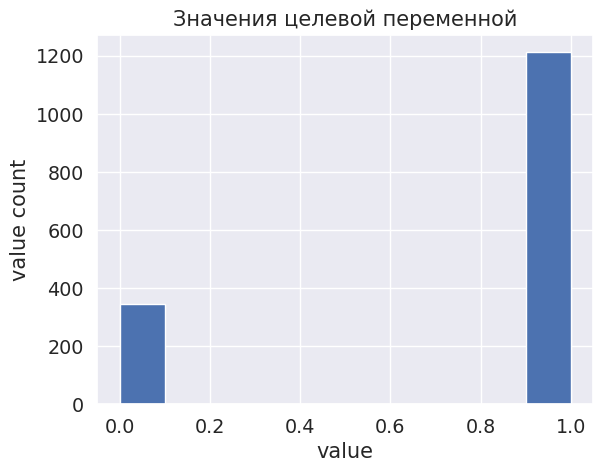

In [ ]:
plt.hist(data[target])
plt.grid()
plt.title('Значения целевой переменной')
plt.xlabel('value')
plt.ylabel('value count')
plt.show()

Значения целевой переменной целочисленные [0, 1], наблюдается дисбаланс классов

### Анализ признаков

* Перевод категориальных признаков в численные
* Анализ корреляции признаков

In [ ]:
print('Категориальные признаки: ')
for column in data.columns:
  if data[column].dtype == 'O':
    print(column, ':', len(data[column].value_counts()))

Категориальные признаки: 
house : 4


In [ ]:
# Закодируем one-hot encoding
one_hot = pd.get_dummies(data['house'])
for column in one_hot.columns:
  one_hot[column] = one_hot[column].astype(int)
data = pd.concat([data, one_hot], axis=1)
data = data.drop('house', axis=1)

In [ ]:
data.head()

,title,male,culture,book1,book2,book3,book4,book5,isMarried,isNoble,boolDeadRelations,isPopular,isAlive,House Frey,House Stark,Night's Watch,Rare
S.No,,,,,,,,,,,,,,,,,
1,1,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0
2,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0
3,1,1,1,0,0,0,1,0,0,1,0,1,1,0,0,0,1
4,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1
5,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,1


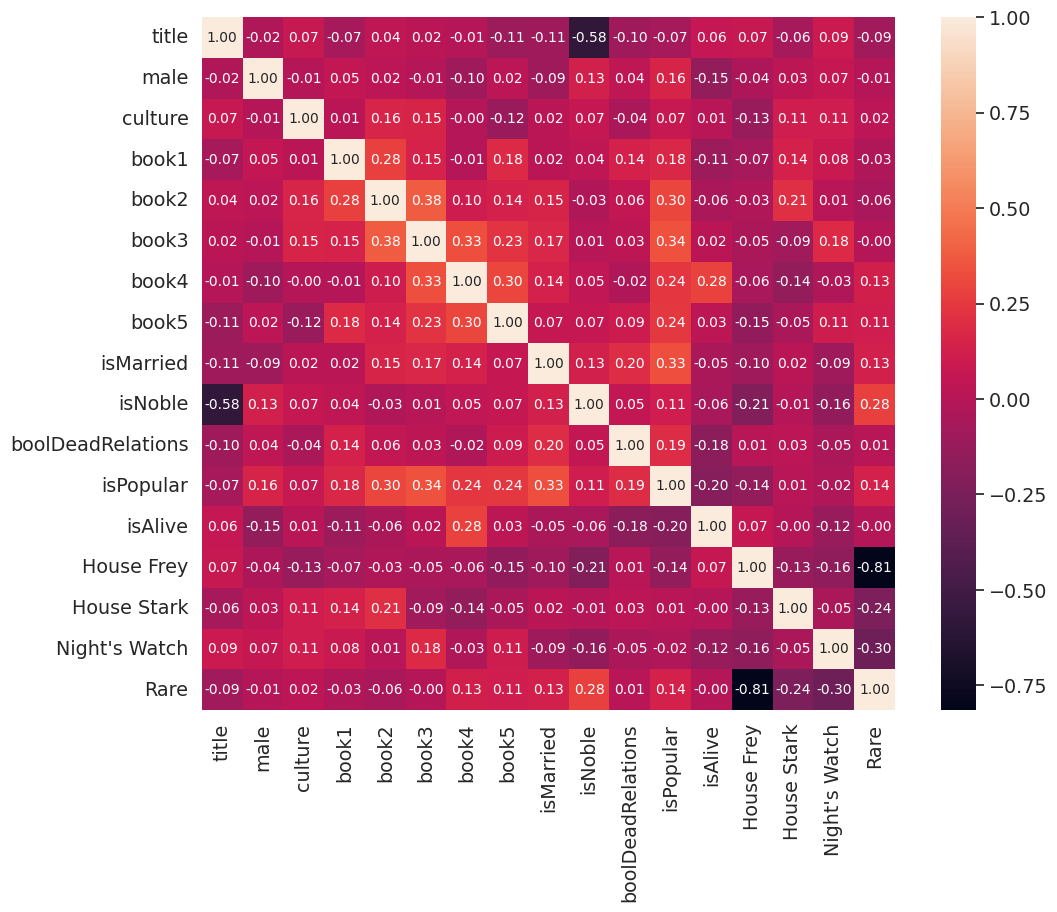

In [ ]:
# Анализ корреляции признаков
f, ax = plt.subplots(figsize=(12, 9))
corrmat = data.corr()
k = 10 # number of variables for heatmap
cols = corrmat.index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
# В силу высокой отрицательной корреляции признаков 'Rare' и 'House Frey' удалим признак 'Rare'
data = data.drop(columns=['Rare'])

In [ ]:
# В силу заметной корреляции признаков title, isNoble между собой, соединим их в один
data['title'] = data['title'] / 2 + np.cos(data['isNoble'])
data = data.drop(columns=['isNoble'])

In [ ]:
# Заметим, что появление в книгах (признаки bookN) умеренно коррелировано, так что соединим эти признаки в один.
# При этом появление в книге 4 наболее кореллировано с целево переменной, так что сделаем этой книге больший вес.
weight_book4 = 2
data['book1'] = np.cos(data['book1']) + weight_book4 * data['book4']
data = data.drop(columns=['book2', 'book3', 'book4', 'book5'])

In [ ]:
# Так как признаки isPopular и isMarried умеренно коррелированы и признак isMarried не коррелирован с целевой переменной, удалим признак isMarried
data = data.drop(columns=['isMarried'])

In [ ]:
# Признак книги и дома Старков скоррелированы, но признак дома Старков не коррелирован с целевой переменной, так что уберем этот признак
# Признаки title, House Frey больше скоррелированы с признаком isPopular, чем с целевой переменной, так что удалим их
data = data.drop(columns=['House Stark', 'House Frey', 'title'])

In [ ]:
# Признаки isPopular и boolDeadRelations, male и isPopular коррелируют между собой примерно так же, как и между целевой переменной, так что соединим их
data['isPopular'] += data['boolDeadRelations']
data['isPopular'] += data['male'] / 2
data = data.drop(columns=['boolDeadRelations', 'male'])

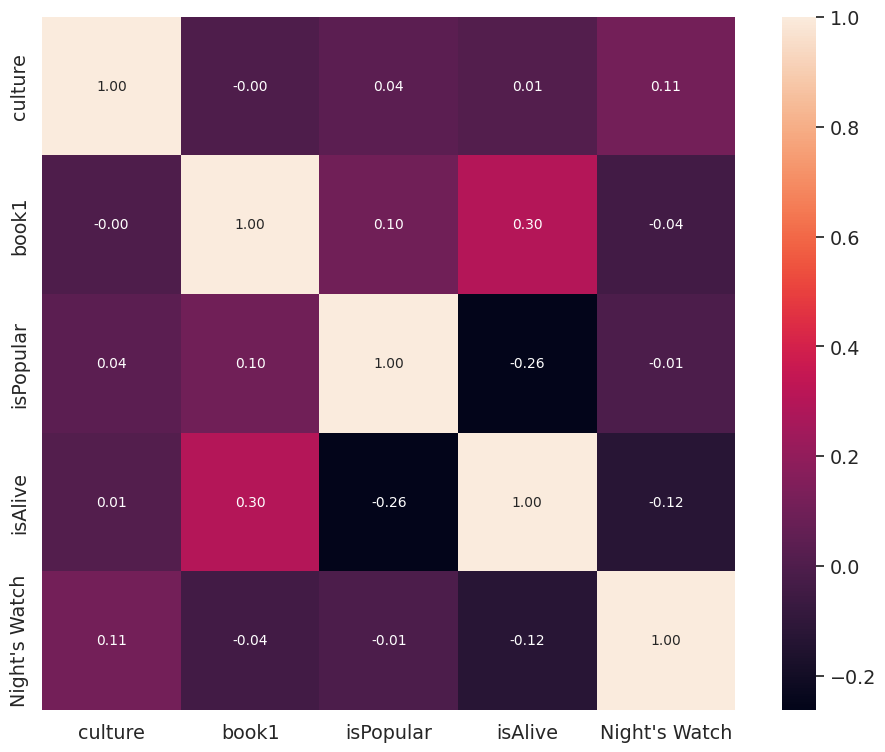

In [ ]:
# Корреляция признаков
f, ax = plt.subplots(figsize=(12, 9))
corrmat = data.corr()
k = 10 # number of variables for heatmap
cols = corrmat.index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Анализ влияния признаков на целевую переменную

In [ ]:
# Круговая диаграмма
def diagram(column):
  classes = data[column].value_counts().index
  data_diag = [data[data[column] == cls]['isAlive'].value_counts() for cls in classes]

  fig, axes = plt.subplots(1, len(data_diag), figsize=(10,8))
  for i, data_d in enumerate(data_diag):
    axes[i].pie(data_d.values, labels=data_d.index, autopct='%1.1f%%')
    axes[i].set_title(f'{column} = {classes[i]}')
  plt.show()

In [ ]:
# box plot
def plot(column):
  plt.figure(figsize=(10, 7))
  plt.boxplot([data[column][data['isAlive'] == 0], data[column][data['isAlive'] == 1]])

  plt.title(f'Влияние "{column}" на выживаемость')
  plt.xlabel('Выжили')
  plt.ylabel(column)
  plt.xticks([1, 2], ['Нет', 'Да'])

  plt.show()

In [ ]:
data.head(1)

,culture,book1,isPopular,isAlive,Night's Watch
S.No,,,,,
1,1,1.0,2.5,0,0


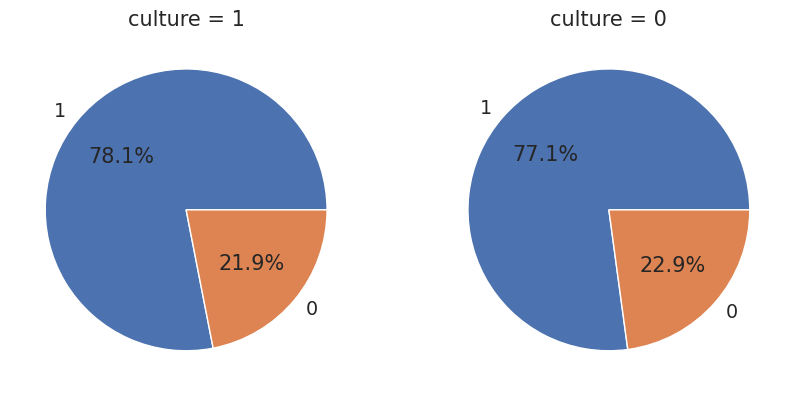

In [ ]:
diagram('culture')

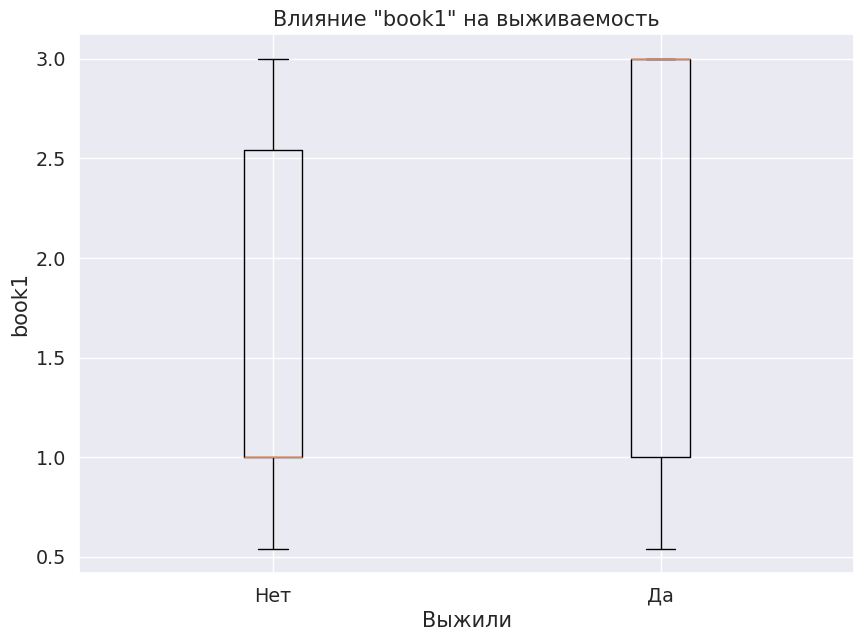

In [ ]:
plot('book1')

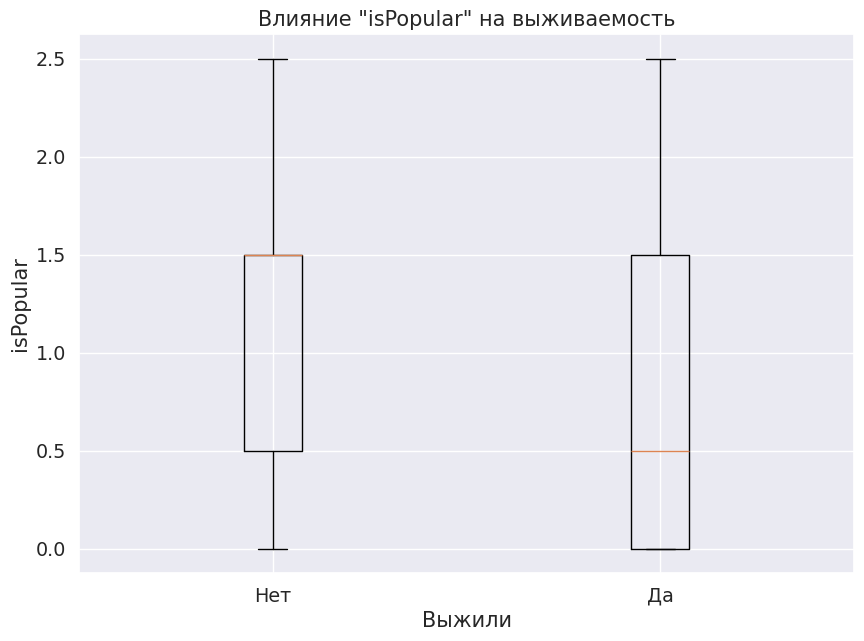

In [ ]:
plot('isPopular')

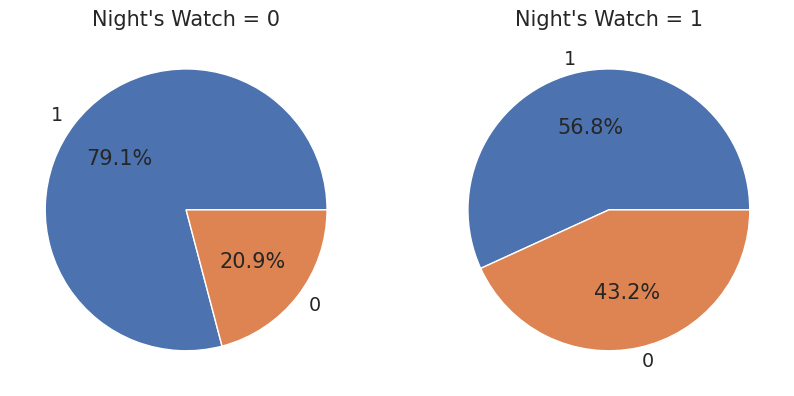

In [ ]:
diagram("Night's Watch")

In [ ]:
# Можно заметить, что признак 'culture' несильно влияет на целевую переменную, так что удалим его
data = data.drop(columns=['culture'])

## Создание датасетов

In [ ]:
X = data.drop(columns=['isAlive'])
y = data['isAlive']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Так как дисбаланс классов, используем параметр stratify
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, shuffle=True, stratify=y.values, test_size=0.15, random_state=42)

# Обучение моделей классификации

## Импорт моделей

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Обучение и предсказание

In [ ]:
# Нормирование данных
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train, X_test = ss.transform(X_train), ss.transform(X_test)

In [ ]:
y_pred = {}

In [ ]:
# Шаг 1. создание модели
models = {'LogisticRegression': LogisticRegression(),
          'AdaBoostClassifier': AdaBoostClassifier(),
          'RandomForestClassifier': RandomForestClassifier(random_state=42),
          'GaussianProcessClassifier': GaussianProcessClassifier(),
          'GuassianNB': GaussianNB(),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'SVC': SVC(),
          'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42)}

In [ ]:
# Шаг 2. обучение модели
for model in models:
  models[model].fit(X_train, y_train)

In [ ]:
# Шаг 3. Предсказание на тестовых данных
for model in models:
  y_pred[model] = models[model].predict(X_test)

# Оценка качества моделей

Используется метрика accuracy

## Выбор лучшей модели

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy = {}
for model in models:
  accuracy[model] = accuracy_score(y_test, y_pred[model])

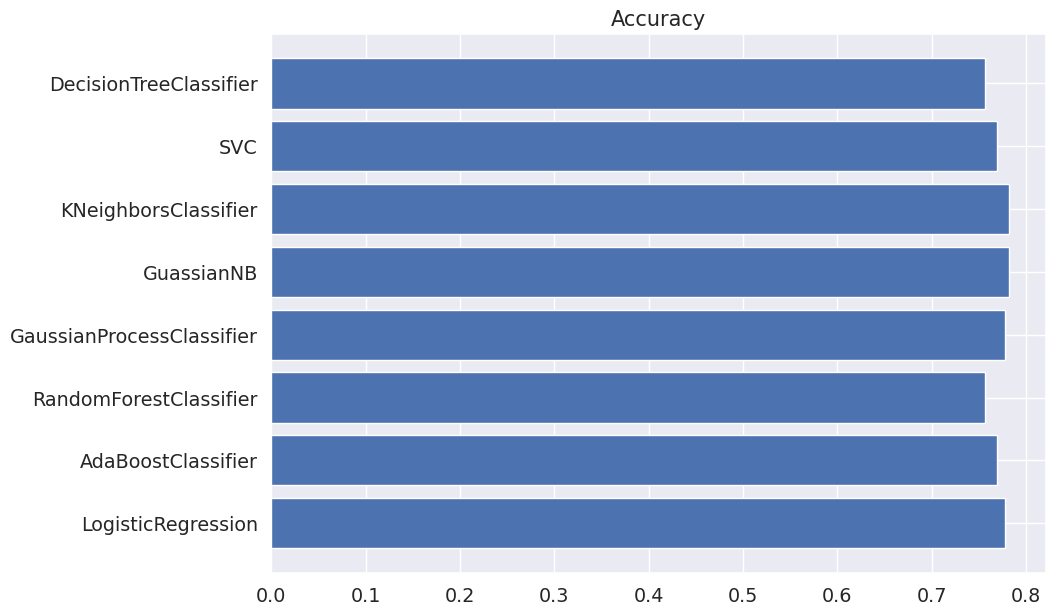

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Accuracy')
plt.barh(list(accuracy.keys()), list(accuracy.values()))
plt.show()

## Подбор гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV

X_valid, y_valid = X_test, y_test

param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

gridsearch = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, refit=True, scoring='f1_weighted', cv=3)
gridsearch.fit(X_valid, y_valid)
best_model = gridsearch.best_estimator_

In [ ]:
best_model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced')

## Файл решения `submission.csv`

In [ ]:
# созданим тестовые данные
test_data = pd.read_csv('/content/game_of_thrones_test.csv', index_col='S.No')
# изменим их так же, как train
test_data['numDeadRelations'] = (test_data['numDeadRelations'] > 0).astype(int)
test_data['popularity'] = (test_data['popularity'] > threshold_popularity).astype(int)
test_data['popularity'] += test_data['numDeadRelations'] + test_data['male'] / 2
test_data['house'] = (test_data['house'] == "Night's Watch").astype(int)
test_data['book1'] = np.cos(test_data['book1']) + weight_book4 * test_data['book4']
test_data = test_data.reindex(columns=['book1', 'popularity', 'house'])

In [ ]:
# Нормирование
X_test = ss.transform(test_data.values)

In [ ]:
# Предсказание
y_pred = best_model.predict(X_test)

In [ ]:
!gdown 1M14conWjAW2QLoyCXbHEAy8bql2f99eF

Downloading...
From: https://drive.google.com/uc?id=1M14conWjAW2QLoyCXbHEAy8bql2f99eF
To: /content/submission.csv
100% 2.74k/2.74k [00:00<00:00, 10.0MB/s]


In [ ]:
submission = pd.read_csv("/content/submission.csv", index_col='S.No')
submission['isAlive'] = y_pred

Сохранение измененного Pandas DataFrame в csv файл:

In [ ]:
submission.to_csv("/content/new_submission.csv", index=False)